# YOLOv8 Training script

Author: Kevin Patel

Date: 4-July-2023

Reference: [Ultralytics github repository](https://github.com/ultralytics/ultralytics)

### Install

!pip install ultralytics

In [2]:
!pwd

/home/kpatel2s/kpatel2s/b_it_bots/2d_object_detection/yolo-object-detection/yolov8


### Imports

In [3]:
import os
import yaml
import numpy as np
import glob as glob
import matplotlib.pyplot as plt
import cv2
import random
from ultralytics import YOLO

## Prepare the Dataset

Dataset for RoboCup 2023 competition | Source: [HBRS Bib cloud](https://bib-cloud.bib.hochschule-bonn-rhein-sieg.de/apps/files/?dir=/Shared/b-it-bots-ds/atwork/images/object_detection/YOLO/robocup_2023_dataset&fileid=16051420) (require HBRS library login credential)

The dataset is structured in the following manner:

```
├── README.md
├── robocup_2023_dataset
        train
        ├── images
        └── labels
        val
        ├── images
        └── labels
        dataset.yaml

```

## The Dataset YAML File

The dataset YAML (`dataset.yaml`) file containing the path to the training and validation images and labels. This file will also contain the class names from the dataset.

The dataset contains 16 classes.

The following block shows the contents of the `dataset.yaml` file.

```yaml
names:
- Axis2
- Bearing2
- Drill
- F20_20_B
- F20_20_G
- Housing
- M20
- M20_100
- M30
- Motor2
- S40_40_B
- S40_40_G
- Screwdriver
- Spacer
- Wrench
nc: 15
train: train/images
val: val/images

```

## Visualize a Few Ground Truth Images

In YOLO format, [x_center, y_center, width, height]


```
A------------------------
-------------------------
-------------------------
-------------------------
-------------------------
------------------------B
```

In Bounding Box format, A [x_min, y_min] and B [x_max, y_max].


Visualize 4 random samples from Dataset [Reference](https://www.youtube.com/watch?v=Ciy1J97dbY0&ab_channel=LearnOpenCV)

In [4]:
# dataset.yaml file
data_yaml = "/home/kpatel2s/kpatel2s/b_it_bots/2d_object_detection/yolo-object-detection/robocup_2023_dataset_308_461/dataset.yaml"

In [5]:
# check if the dataset.yaml file exists
if not os.path.exists(data_yaml):
    print("dataset.yaml file does not exist. Please check the path.")
    exit()

# load the dataset.yaml file
with open(data_yaml, 'r') as stream:
    data_yaml_dict = yaml.safe_load(stream)

# class names
class_names = data_yaml_dict['names']
print("Class names: ", class_names)
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

Class names:  ['Axis2', 'Bearing2', 'Drill', 'F20_20_B', 'F20_20_G', 'Housing', 'M20', 'M20_100', 'M30', 'Motor2', 'S40_40_B', 'S40_40_G', 'Screwdriver', 'Spacer', 'Wrench']


In [6]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [7]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin

        class_name = class_names[int(labels[box_num])]

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        )

        font_scale = min(1, max(3, int(w/500)))
        font_thickness = min(2, max(10, int(w/50)))

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name,
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image,
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image,
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [8]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    # Get files at image_paths and label_paths
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    
    # all_training_images = glob.glob(image_paths)
    # all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()

    num_images = len(all_training_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0, num_images-1)
        # j = 0
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line.split(' ')[0]
                bbox_string = label_line.split(' ')[1:]
                x_c, y_c, w, h = bbox_string
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h.split('\n')[0])
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()


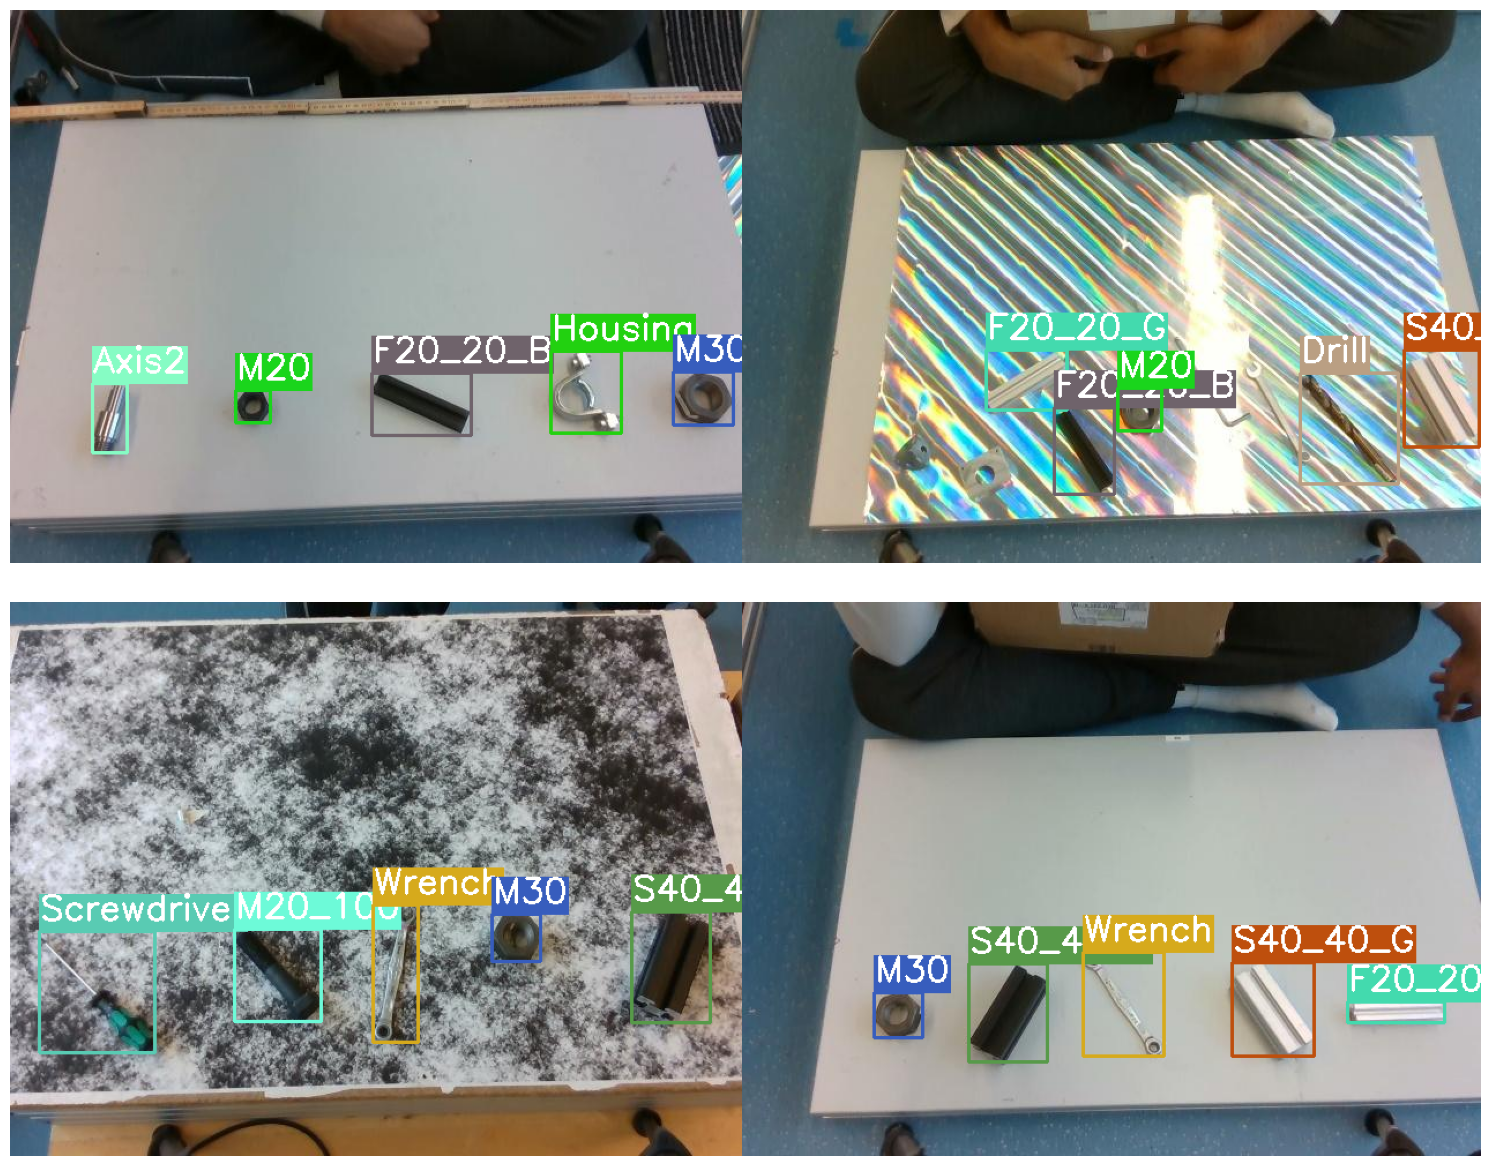

In [9]:
# Visualize a few training images.
plot(
    image_paths=os.path.join(os.path.dirname(data_yaml), data_yaml_dict['train'], '*'),
    label_paths=os.path.join(os.path.dirname(data_yaml), data_yaml_dict['train'].replace('images', 'labels'), '*'),
    num_samples=4,
)

## Inputs and Hyperparameters for training

In [10]:
# Inputs
pretrained_model = 'yolov8s.pt' # default is yolov8n.pt
config_file = "/home/kpatel2s/kpatel2s/b_it_bots/2d_object_detection/yolo-object-detection/yolov8/yolov8_config_robocup_2023.yaml"
data_yaml = "/home/kpatel2s/kpatel2s/b_it_bots/2d_object_detection/yolo-object-detection/robocup_2023_dataset_308_461/dataset.yaml"

# Hyperparameters
epochs = 10
image_size = 640
batch_size = 64 # (-1 for AutoBatch, works only for single GPU)
project_name = "yolov8_robocup_2023/train" # save training results to <project-name>/train
file_name = os.path.basename(os.path.splitext(pretrained_model)[0])
model_name = f"{file_name}_epoch{epochs}_" if file_name != 'best' else f"{pretrained_model.split('/')[-3]}_epoch{epochs}_"
cuda_devices = '0' # GPU devices ids 
freeze_layers = 10 # number of layers to freeze (from the beginning)

In [11]:
def freeze_layer(trainer):
    model = trainer.model
    num_freeze = freeze_layers
    print(f"Freezing {num_freeze} layers")
    freeze = [f'model.{x}.' for x in range(num_freeze)]  # layers to freeze 
    for k, v in model.named_parameters(): 
        v.requires_grad = True  # train all layers 
        if any(x in k for x in freeze): 
            print(f'freezing {k}') 
            v.requires_grad = False 
    print(f"{num_freeze} layers are freezed.")

In [12]:
# Load a model
model = YOLO(pretrained_model)  # load a pretrained model (recommended for training)
# model.add_callback("on_train_start", freeze_layer) # DOESN"T IMPROVE PERFORMANCE

In [13]:
# Train a model using custom config yaml file
model.train(cfg=config_file, # custom config file
            data=data_yaml,
            epochs=epochs,
            imgsz=image_size,
            batch=batch_size,
            project=project_name,
            name=model_name,
            device=cuda_devices,
            pretrained=True,
            )

New https://pypi.org/project/ultralytics/8.0.113 available 😃 Update with 'pip install -U ultralytics'
cfg file passed. Overriding default params with /home/kpatel2s/kpatel2s/b_it_bots/2d_object_detection/yolo-object-detection/yolov8/yolov8_config_robocup_2023.yaml.
Ultralytics YOLOv8.0.112 🚀 Python-3.8.16 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24268MiB)
yolo/engine/trainer: task=detect, mode=train, model=None, data=/home/kpatel2s/kpatel2s/b_it_bots/2d_object_detection/yolo-object-detection/robocup_2023_dataset_308_461/dataset.yaml, epochs=10, patience=100, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=yolov8_robocup_2023/train, name=yolov8s_epoch10_, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False

##### NOTE: To free up GPU memory, follow these steps:https://askubuntu.com/a/1118325/922137

## Monitor Model on TensorBoard

In [14]:
!tensorboard --logdir <path-to-result-directory> --port 6006

/bin/bash: path-to-result-directory: No such file or directory


## Validation and Inference

In [15]:
if project_name:
    dir_count = len(glob.glob(project_name+'/' + model_name + '*'))
    if dir_count == 1:
        RESULT_DIR = project_name + "/" + model_name
    else:
        RESULT_DIR = project_name + "/" + model_name + str(dir_count)
    
else:
    #### USER INPUT
    # Give a result directory name where the training results are saved.
    RESULT_DIR = "runs/train"

RESULT_DIR

'yolov8_robocup_2023/train/yolov8s_epoch10_2'

### Inference Utilities

In [16]:
# Function to show validation predictions saved during training.
def show_valid_results(RES_DIR):
    EXP_PATH = f"{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    if len(validation_pred_images) == 0:
        print("No validation predictions found.")
        return
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

The following functions are for carrying out inference on images/videos.

In [17]:
# Helper function for inference on images.
def inference(RES_DIR, data_path):
    # check data_path
    if not os.path.exists(data_path):
        print(f"Data path {data_path} doesn't exist.")
        return
    # Inference on images.
    image_size = 640
    confidence_threshold = 0.45
    iou_threshold = 0.45
    half_precision = True # use FP16 half-precision inference (faster, less accurate)
    project_name = f"{RES_DIR.split('/')[0]}/predictions" # save inference results to <project-name>/detect
    model_name = f"{RES_DIR.split('/')[2]}_inference"
    cuda_devices = '0' # GPU devices ids

    # Prediction on test images
    model.predict(source=data_path,
                conf=confidence_threshold,
                iou=iou_threshold,
                half=half_precision,
                device=cuda_devices,
                save=True,
                project=project_name,
                name=model_name)
    
    dir_count = len(glob.glob(project_name+'/' + model_name + '*'))
    if dir_count == 1:
        INFER_DIR = project_name + "/" + model_name
    else:
        INFER_DIR = project_name + "/" + model_name + str(dir_count)
    
    return INFER_DIR

In [18]:
def visualize(INFER_DIR):
    # Visualize inference images.
    INFER_PATH = f"{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}/*")
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

#### Visualize validation prediction images

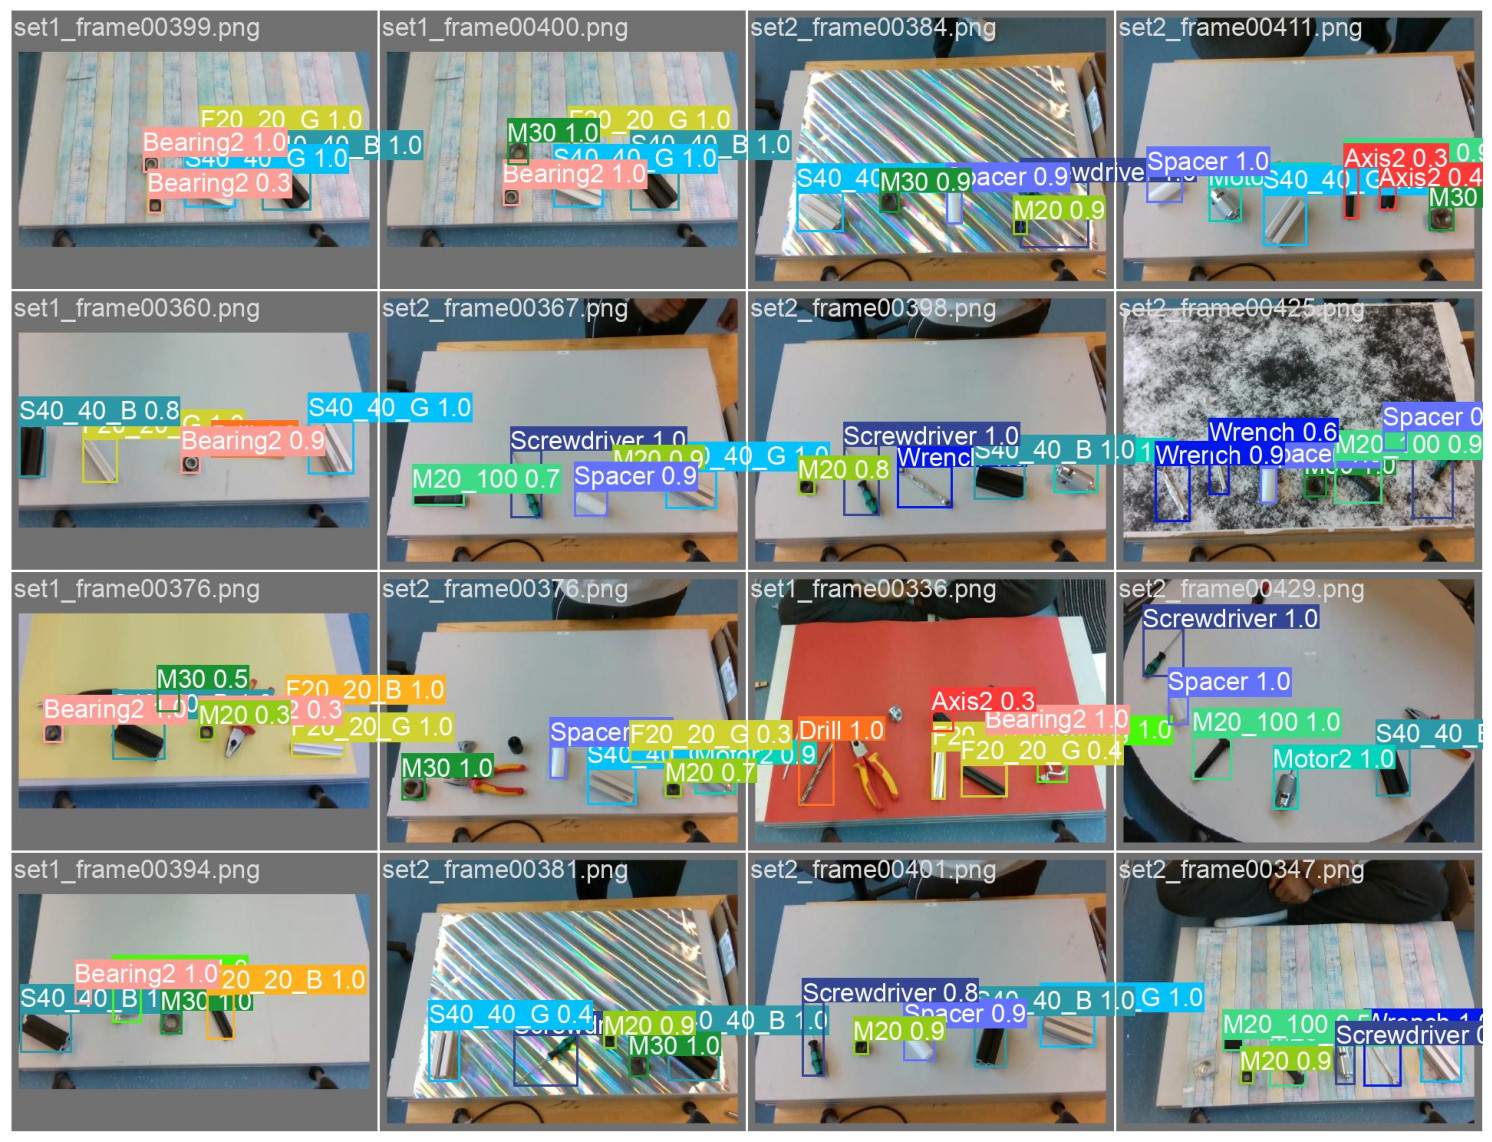

In [19]:
show_valid_results(RESULT_DIR)

### Inference
In this section, we will carry out inference on unseen images. 

The images for inference are in the `test_images_robocup_2023` directory.

**To carry out inference on images, we just need to provide the directory path where all the images are stored, and inference will happen on all images automatically.**

In [20]:
on_single_image = True

if on_single_image:
    # Inference on single image
    IMAGE_INFER_DIR = inference(RESULT_DIR, '/home/kpatel2s/kpatel2s/b_it_bots/2d_object_detection/yolo-object-detection/test_images_robocup_2023/set2_frame00000.png')
else:
    # Inference on images.
    IMAGE_INFER_DIR = inference(RESULT_DIR, '/home/kpatel2s/kpatel2s/b_it_bots/2d_object_detection/yolo-object-detection/test_images_robocup_2023')

IMAGE_INFER_DIR


image 1/1 /home/kpatel2s/kpatel2s/b_it_bots/2d_object_detection/yolo-object-detection/test_images_robocup_2023/set2_frame00000.png: 480x640 1 F20_20_B, 1 F20_20_G, 1 M20, 1 M20_100, 1 M30, 63.0ms
Speed: 0.8ms preprocess, 63.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to yolov8_robocup_2023/predictions/yolov8s_epoch10_2_inference


'yolov8_robocup_2023/predictions/yolov8s_epoch10_2_inference'

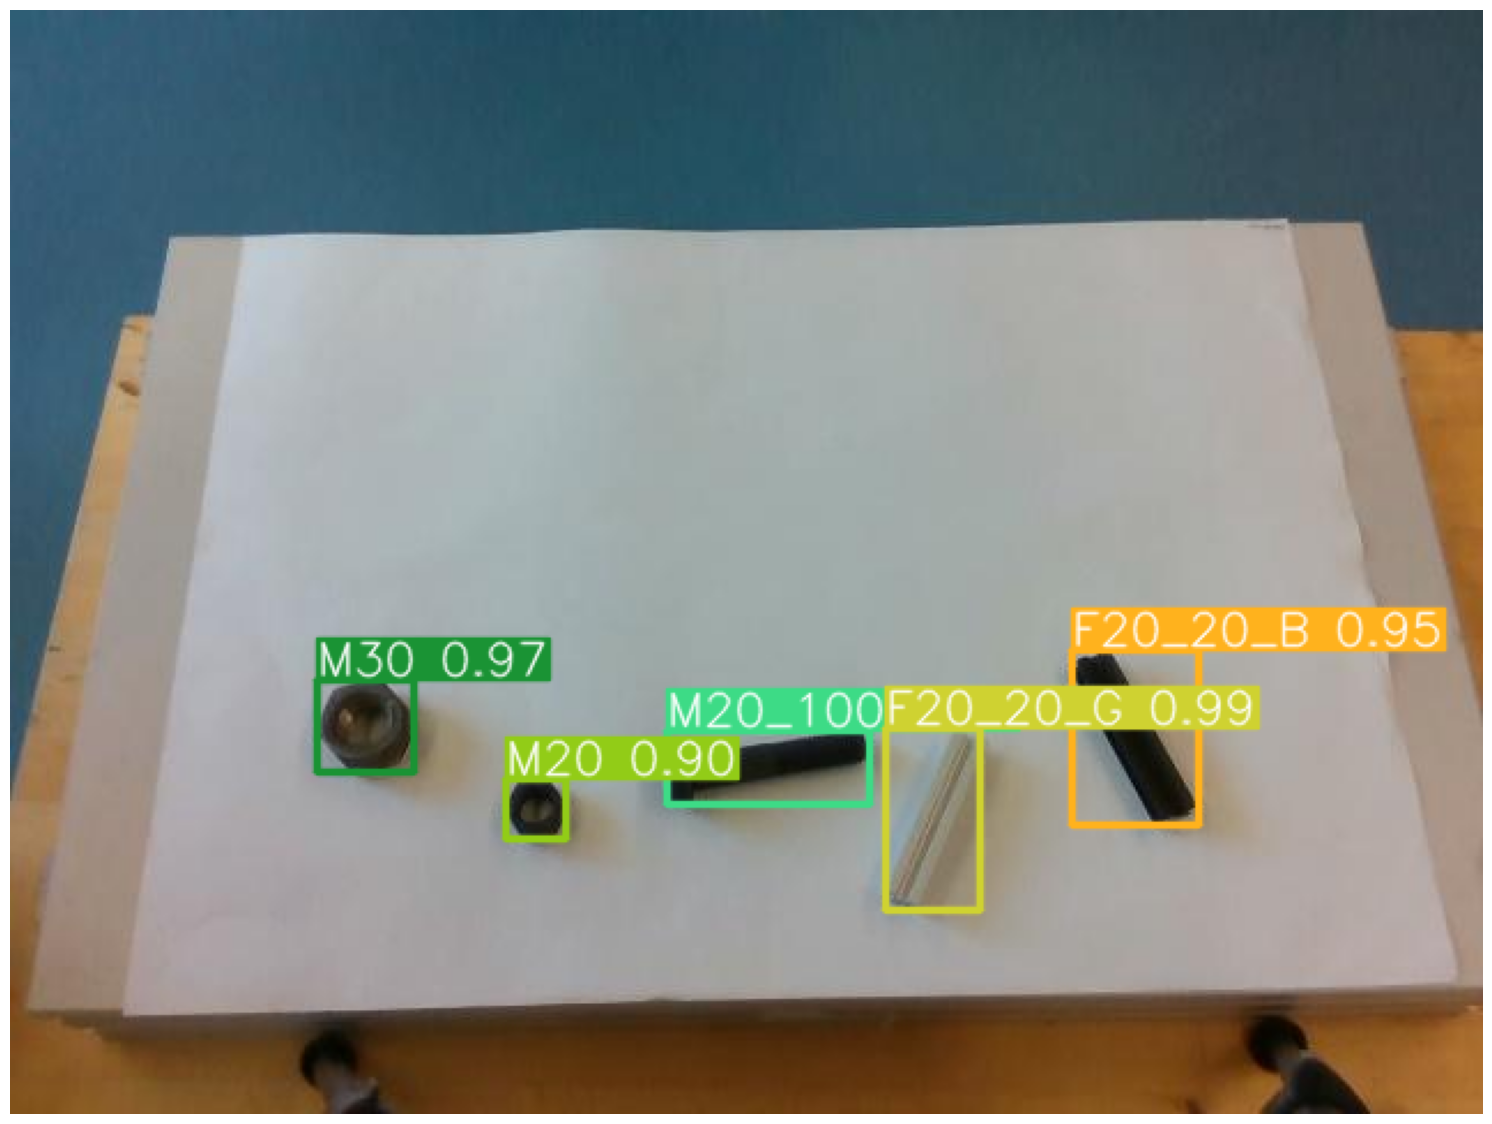

In [21]:
# IMAGE_INFER_DIR
visualize(IMAGE_INFER_DIR)

## Export model (.pt) to ONNX model (.onnx)
##### Reference: https://docs.ultralytics.com/modes/export/

In [22]:
# Export model to ONNX
path = model.export(format="onnx", opset=12)
print("Exported model to: ", path)

Ultralytics YOLOv8.0.112 🚀 Python-3.8.16 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24268MiB)

PyTorch: starting from yolov8_robocup_2023/train/yolov8s_epoch10_2/weights/best.pt with input shape (64, 3, 640, 640) BCHW and output shape(s) (64, 19, 8400) (21.5 MB)

ONNX: starting export with onnx 1.14.0 opset 12...


============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



ONNX: export success ✅ 0.7s, saved as yolov8_robocup_2023/train/yolov8s_epoch10_2/weights/best.onnx (42.7 MB)

Export complete (1.1s)
Results saved to /home/kpatel2s/kpatel2s/b_it_bots/2d_object_detection/yolo-object-detection/yolov8/yolov8_robocup_2023/train/yolov8s_epoch10_2/weights
Predict:         yolo predict task=detect model=yolov8_robocup_2023/train/yolov8s_epoch10_2/weights/best.onnx imgsz=640 
Validate:        yolo val task=detect model=yolov8_robocup_2023/train/yolov8s_epoch10_2/weights/best.onnx imgsz=640 data=/home/kpatel2s/kpatel2s/b_it_bots/2d_object_detection/yolo-object-detection/robocup_2023_dataset_308_461/dataset.yaml 
Visualize:       https://netron.app


Exported model to:  yolov8_robocup_2023/train/yolov8s_epoch10_2/weights/best.onnx
